In [1]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update

# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
# !mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
# !apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
# !add-apt-repository "deb http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/ /"

# !apt-get update
# !apt-get -y install cuda-10-1

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [3]:
!nvidia-smi

Wed Dec 21 12:45:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# !apt-get install nvidia-visual-profiler

In [5]:
!wget https://raw.githubusercontent.com/NVIDIA/cuda-samples/master/Common/helper_cuda.h

--2022-12-21 12:45:54--  https://raw.githubusercontent.com/NVIDIA/cuda-samples/master/Common/helper_cuda.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27792 (27K) [text/plain]
Saving to: ‘helper_cuda.h’

helper_cuda.h       100%[===================>]  27.14K  --.-KB/s    in 0.001s  

2022-12-21 12:45:54 (22.1 MB/s) - ‘helper_cuda.h’ saved [27792/27792]



# measuring data transfer rate

In [6]:
%%writefile test.cu
#include <stdio.h>
#include <stdlib.h>


#define N (2048*512)


__global__ void vec_add(float *, float *, float *);


int  main(int argc, char *argv[])
{
  unsigned int i, n = N;
  float *A_h, *B_h, *C_h, *A_d, *B_d, *C_d;

  A_h = (float *) malloc(n*sizeof(float)); for(i = 0; i < n; i++) A_h[i] = 1.0;
  B_h = (float *) malloc(n*sizeof(float)); for(i = 0; i < n; i++) B_h[i] = 2.0;
  C_h = (float *) malloc(n*sizeof(float)); for(i = 0; i < n; i++) C_h[i] = 0.0;

  cudaMalloc((void**) &A_d, n*sizeof(float));
  cudaMalloc((void**) &B_d, n*sizeof(float));
  cudaMalloc((void**) &C_d, n*sizeof(float));

  cudaMemcpy(A_d, A_h, n*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(B_d, B_h, n*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(C_d, C_h, n*sizeof(float), cudaMemcpyHostToDevice);

  cudaDeviceSynchronize();

  int count = 10000;

  cudaEvent_t start, stop;

  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  cudaEventRecord(start);

  dim3  grid(n/512, 1),  block(512, 1);

  for(i = 0; i < count; i++) {
    vec_add<<< grid, block>>>(A_d, B_d, C_d);
  }
  cudaMemcpy(C_h, C_d, n*sizeof(float), cudaMemcpyDeviceToHost);

  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  double ave = 0.0;
  for(i = 0; i < n; i++) ave += C_h[i];
  ave /= (float)n;

  float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  printf("Data size=%4.1f[MB]\nTime to generate:  %3.1f [ms] \n", (float)n*4.0*1.0e-06, milliseconds);
  printf("Average = %8.6f\n",ave);
  return 0;
}


__global__ void vec_add(float *A, float *B, float *C){
    int i = blockDim.x*blockIdx.x + threadIdx.x;
#ifdef __DEVICE_EMULATION__
    if(blockIdx.x == 3) printf("threadIdx.x = %d\n",threadIdx.x);
#endif
    C[i] = A[i] + B[i];
}


Writing test.cu


In [7]:
!nvcc test.cu --ptxas-options=-v -o test

ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z7vec_addPfS_S_' for 'sm_52'
ptxas info    : Function properties for _Z7vec_addPfS_S_
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 8 registers, 344 bytes cmem[0]


In [8]:
!./test

Data size= 4.2[MB]
Time to generate:  512.5 [ms] 
Average = 3.000000


# fluid dynamics

In [9]:
%%writefile diffusion2d.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "func.h"

#define BLOCK_DIM_X 256
#define BLOCK_DIM_Y 8

__global__ void diffusion_2d_cuda(float *dependent_var, float *updated_dependent_var,
                                  int grid_size_x, int grid_size_y, float coef_0, float coef_1, float coef_2)
{
    int j, js = threadIdx.x + 1, jy, j0 = 0, j1 = 1, j2 = 2, tmp;
    __shared__ float shared_fs[3][BLOCK_DIM_X + 2];

    jy = BLOCK_DIM_Y * blockIdx.y;
    j = grid_size_x * jy + blockDim.x * blockIdx.x + threadIdx.x;
    shared_fs[j1][js] = dependent_var[j];

    if (blockIdx.y == 0)
        shared_fs[j0][js] = shared_fs[j1][js];
    else
        shared_fs[j0][js] = dependent_var[j - grid_size_x];
    j += grid_size_x;

#pragma unroll
    for (jy = 0; jy < BLOCK_DIM_Y; jy++)
    {
        if (blockIdx.y == gridDim.y - 1)
            shared_fs[j2][js] = shared_fs[j1][js];
        else
            shared_fs[j2][js] = dependent_var[j];

        if (threadIdx.x == 0)
        {
            if (blockIdx.x == 0)
                shared_fs[j1][0] = shared_fs[j1][1];
            else
                shared_fs[j1][0] = dependent_var[j - grid_size_x - 1];
        }
        if (threadIdx.x == blockDim.x - 1)
        {
            if (blockIdx.x == gridDim.x - 1)
                shared_fs[j1][js + 1] = shared_fs[j1][js];
            else
                shared_fs[j1][js + 1] = dependent_var[j - grid_size_x + 1];
        }

        __syncthreads();

        updated_dependent_var[j - grid_size_x] = coef_0 * (shared_fs[j1][js - 1] + shared_fs[j1][js + 1]) +
                                                 coef_1 * (shared_fs[j0][js] + shared_fs[j2][js]) +
                                                 coef_2 * shared_fs[j1][js];

        j += grid_size_x;

        tmp = j0;
        j0 = j1;
        j1 = j2;
        j2 = tmp;
    }
}

void diffusion_2d_cpu(float *f, float *fn, int nx, int ny, float c0, float c1, float c2) {
    int i, x, y;
    float center, east, west, south, north;

    for (y = 0; y < ny; y++) {
        for (x = 0; x < nx; x++) {
            i = nx*y + x;
            center = f[i];

            if (x == 0) {
                west = center;
            } else {
                west = f[i - 1];
            }

            if (x == nx - 1) {
                east = center;
            } else {
                east = f[i + 1];
            }

            if (y == 0) {
                south = center;
            } else {
                south = f[i - nx];
            }

            if (y == ny - 1) {
                north = center;
            } else {
                north = f[i + nx];
            }

            fn[i] = c0*(east + west) + c1*(north + south) + c2*center;
        }
    }
}

float diffusion_2d(int num_gpus, int grid_size_x, int grid_size_y, float *dependent_var, float *updated_dependent_var,
                  float diff_coef, float time_step, float grid_spacing_x, float grid_spacing_y)
{
    float coef_0 = diff_coef * time_step / (grid_spacing_x * grid_spacing_x);
    float coef_1 = diff_coef * time_step / (grid_spacing_y * grid_spacing_y);
    float coef_2 = 1.0 - 2.0 * (coef_0 + coef_1);

    if (num_gpus > 0)
    {
        dim3 grid(grid_size_x / BLOCK_DIM_X, grid_size_y / BLOCK_DIM_Y, 1);
        dim3 threads(BLOCK_DIM_X, 1, 1);
        diffusion_2d_cuda<<<grid, threads>>>(dependent_var, updated_dependent_var, grid_size_x, grid_size_y, coef_0, coef_1, coef_2);

        cudaDeviceSynchronize();
    }
    else
    {
        diffusion_2d_cpu(dependent_var, updated_dependent_var, grid_size_x, grid_size_y, coef_0, coef_1, coef_2);
    }

    return (float)(grid_size_x * grid_size_y) * 7.0;
}

Writing diffusion2d.cu


In [10]:
%%writefile etc.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda.h>
#include "func.h"

void swap_variables(float **dependent_variable, float **updated_variable) {
  float *temp = *dependent_variable;
  *dependent_variable = *updated_variable;
  *updated_variable = temp;
}

void allocate_memory(int num_gpus, int x_size, int y_size, float **dependent_variable, float **updated_variable) {
  int size = x_size * y_size;
  if (num_gpus > 0) {
    cudaError_t error = cudaMalloc((void**)dependent_variable, x_size * y_size * sizeof(float));
    if (error != cudaSuccess) {
      printf("Error: %s\n", cudaGetErrorString(error));
      exit(EXIT_FAILURE);
    }
    error = cudaMalloc((void**)updated_variable, x_size * y_size * sizeof(float));
    if (error != cudaSuccess) {
      printf("Error: %s\n", cudaGetErrorString(error));
      exit(EXIT_FAILURE);
    }
  } else {
    *dependent_variable = (float*)malloc(sizeof(float) * size);
    *updated_variable = (float*)malloc(sizeof(float) * size);
  }
}

void generate_bmp_image(int num_gpus, int x_size, int y_size, float *dependent_variable, int multiple_scale, float max_value, float min_value, char *filename, char *palette) {
  int j, jx, jy, ix, iy, jmx, jmy, mul_x, mul_y;
  float gux, guy, fc, gmax = -1.0e+30, gmin = 1.0e+30, f0, f1, *data;
  static int mx = 0, my = 0;
  char *image_data;

  mx = multiple_scale * (x_size - 1) + 1;
  my = multiple_scale * (y_size - 1) + 1;
  image_data = (char*)malloc(sizeof(float) * mx * my);

  if (num_gpus > 0) {
    data = (float*)malloc(x_size * y_size * sizeof(float));
    cudaMemcpy(data, dependent_variable, x_size * y_size * sizeof(float), cudaMemcpyDeviceToHost);
  } else {
    data = dependent_variable;
  }

  for (jy = 0; jy < y_size - 1; jy++) {
    for (jx = 0; jx < x_size - 1; jx++) {
      j = x_size * jy + jx;

      if (jx == x_size - 1) mul_x = 1;
      else mul_x = multiple_scale;
      if (jy == y_size - 1) mul_y = 1;
      else mul_y = multiple_scale;
      for (jmy = 0; jmy < mul_y; jmy++) {
        iy = multiple_scale * jy + jmy;
        iy = my - 1 - iy;
        for (jmx = 0; jmx < mul_x; jmx++) {
          ix = multiple_scale * jx + jmx;
          gux = (float)jmx / (float)mul_x;
          guy = (float)jmy / (float)mul_y;

          f0 = (1.0 - gux) * data[j] + gux * data[j + 1];
          f1 = (1.0 - gux) * data[j + x_size] + gux * data[j + x_size + 1];
          fc = (1.0 - guy) * f0 + guy * f1;

          gmax = fmax(gmax, fc);
          gmin = fmin(gmin, fc);
          fc = 253.0 * (fc - min_value) / (max_value - min_value) + 2.0;

          image_data[mx * iy + ix] = (char)fmin(fmax(2.0, fc), 253.0);
        }
      }
    }
  }

  DFR8bmp(image_data, mx, my, filename, palette);
  fprintf(stderr,"filename=%s  ",filename);
  fprintf(stderr,"MAX=%10.3e  MIN=%10.3e\n",gmax, gmin);

  free(image_data);
  if(num_gpus > 0) free(data);

  return;
}


int set_num_gpus(int numGPUs, int argc, char **argv) {
    int usrGPUs;
    if (argc > 1) {
        if (strncmp(argv[1], "-gpu", 4) == 0) {
            usrGPUs = numGPUs;
        } else if (strncmp(argv[1], "-cpu", 4) == 0) {
            usrGPUs = 0;
        } else {
            usrGPUs = numGPUs;
        }
    } else {
        usrGPUs = numGPUs;
    }
    return usrGPUs;
}


Writing etc.cu


In [11]:
%%writefile bmp.cu

#ifndef SLS_PUT_HEADER_BMP
#define SLS_PUT_HEADER_BMP

#include <stdio.h>
#include <stdlib.h>
#include <limits.h>

#include "bmp.h"

#ifndef SLS_FPUTC2LH
#define SLS_FPUTC2LH

int fputc2lh(unsigned short int d, FILE *sput)
{
  if (putc(d & 0xFF, sput) == EOF || putc(d >> CHAR_BIT, sput) == EOF) {
    return EOF;
  }
  return 0;
}

#endif

#ifndef SLS_FPUTC4LH
#define SLS_FPUTC4LH

int fputc4lh(unsigned long int d, FILE *sput)
{
  if (putc(d & 0xFF, sput) == EOF || putc((d >> CHAR_BIT) & 0xFF, sput) == EOF ||
      putc((d >> CHAR_BIT * 2) & 0xFF, sput) == EOF || putc((d >> CHAR_BIT * 3) & 0xFF, sput) == EOF) {
    return EOF;
  }
  return 0;
}

#endif

int put_header_bmp(FILE *sput, int rx, int ry, int cbit)
{
  int i, nx, color;
  unsigned long int bfOffBits;

  if (rx <= 0 || ry <= 0) {
    return IFR_SIZE_ERR;
  }
  if (sput == NULL || ferror(sput)) {
    return IFR_PUT_ERR;
  }
  nx = rx - (rx % 4);
  if (nx < rx) {
    nx += 4;
  }

  if (cbit == 24) {
    color = 0;
  } else {
    color = 1;
    for (i = 1; i <= cbit; i++) {
      color *= 2;
    }
  }
  bfOffBits = 14 + 40 + 4 * color;

  if (fputs("BM", sput) == EOF || fputc4lh(bfOffBits + (unsigned long) nx * ry, sput) == EOF ||
      fputc2lh(0, sput) == EOF || fputc2lh(0, sput) == EOF || fputc4lh(bfOffBits, sput) == EOF ||
      ferror(sput)) {
    return IFR_PUT_ERR;
  }

  if (fputc4lh(40, sput) == EOF || fputc4lh(rx, sput) == EOF || fputc4lh(ry, sput) == EOF ||
      fputc2lh(1, sput) == EOF || fputc2lh(cbit, sput) == EOF || fputc4lh(0, sput) == EOF || fputc4lh(0, sput) == EOF || fputc4lh(0, sput) == EOF ||
      fputc4lh(0, sput) == EOF || fputc4lh(0, sput) == EOF || fputc4lh(0, sput) == EOF || ferror(sput)) {
    return IFR_PUT_ERR;
  }

  return IFR_SUCCESS;
}

#endif

int put_header_bmp(FILE *sput, int nx, int ny, int cbit);


void DFR8bmp(char* data, int width, int height, char* filename, char* palette)
{
    unsigned char pal[768], rgba[4] = {0,0,0,0}, *padded_data;
    int mx, jx, jy;
    FILE *fp, *fc;

    fp = fopen(palette, "rb");
    if (fp != NULL) {
        fread(pal, 1, 768, fp);
        fclose(fp);
    }

    fc = fopen(filename, "wb");
    put_header_bmp(fc, width, height, 8);

    for (int j = 0; j < 256; j++) {
        rgba[0] = pal[3 * j + 2];
        rgba[1] = pal[3 * j + 1];
        rgba[2] = pal[3 * j + 0];
        fwrite(rgba, 1, 4, fc);
    }

    mx = width - (width % 4);
    if (mx < width) {
        mx += 4;
    }

    padded_data = (unsigned char*) calloc(mx * height, sizeof(unsigned char));
    for (jy = 0; jy < height; jy++) {
        for (jx = 0; jx < width; jx++) {
            padded_data[jy * mx + jx] = data[(height - 1 - jy) * width + jx];
        }
    }
    fwrite(padded_data, 1, mx * height, fc);

    fclose(fc);
    free(padded_data);
}


Writing bmp.cu


In [12]:
%%writefile func.h
#pragma once

#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>

#define MAX(x, y) ((x) > (y) ? (x) : (y))
#define MIN(x, y) ((x) < (y) ? (x) : (y))

#define checkCudaErrors(err)  __checkCudaErrors(err, __FILE__, __LINE__)

inline void __checkCudaErrors(cudaError_t err, const char *file, int line)
{
    if (err != cudaSuccess)
    {
        fprintf(stderr, "[Error] %s (error code: %d) at %s line %d\n", cudaGetErrorString(err), err, file, line);
        exit(err);
    }
}

void initial(int numGPUs, int nx, int ny, float dx, float dy, float *f);

float diffusion_2d(int numGPUs, int nx, int ny, float *f, float *fn, float kappa, float dt, float dx, float dy);

void swap_variables(float **f, float **fn);

void allocate_memory(int numGPUs, int nx, int ny, float **f, float **fn);

void generate_bmp_image(int numGPUs, int nx, int ny, float *f, int mul, float fmax, float fmin, char *filename, char *palette);

void DFR8bmp(char *a, int nx, int ny, char *filename, char *palette);

int set_num_gpus(int numGPUs, int argc, char **argv);


Writing func.h


In [13]:
%%writefile bmp.h
#pragma once

#ifndef SLS_IFR_T
#define SLS_IFR_T

typedef enum
{
    IFR_SUCCESS = 0,
    IFR_GET_ERR,
    IFR_PUT_ERR,
    IFR_OPEN_ERR,
    IFR_CLOSE_ERR,
    IFR_FILE_EMPTY,
    IFR_DIFF_FILE,
    IFR_NO_DECODE,
    IFR_DATA_ERR,
    IFR_SIZE_ERR,
    IFR_COLORS_ERR,
    IFR_MEMORY_ERR,
    IFR_CASE1 = 101,
    IFR_CASE2,
    IFR_CASE3,
    IFR_CASE4,
    IFR_CASE5,
    IFR_CASE6,
    IFR_CASE7,
    IFR_CASE8,
    IFR_CASE9,
    IFR_CASE10
} ifr_t;

#endif


Writing bmp.h


In [14]:
%%writefile main.cu
#define  NX  256
#define  NY  256

#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include "func.h"

int main(int argc, char *argv[])
{
  int numGPUs;
  cudaGetDeviceCount(&numGPUs);
  numGPUs = set_num_gpus(numGPUs,argc,argv);

  int nx = NX, ny = NY, icnt = 1, nout = 600;
  float Lx = 1.0, Ly = 1.0;
  float dx = Lx/(float)nx, dy = Ly/(float)ny, kappa = 0.1;
  float *f, *fn, dt, time = 0.0, flops = 0.0;
  char filename[] = "f000.bmp";

  allocate_memory(numGPUs, nx, ny, &f, &fn);
  initial(numGPUs, nx, ny, dx, dy, f);
  dt = (0.20*MIN(dx*dx, dy*dy)/kappa);

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  cudaEventRecord(start);

  do {
    if (icnt % 100 == 0) {
      fprintf(stderr,"time(%4d)=%7.5f\n", icnt, time + dt);
    }
    flops += diffusion_2d(numGPUs, nx, ny, f, fn, kappa, dt, dx, dy);
    swap_variables(&f, &fn);
    time += dt;
    if (icnt % nout == 0) {
      printf("TIME = %9.3e\n", time);
      sprintf(filename, "f%03d.bmp", icnt/nout);
      generate_bmp_image(numGPUs, nx, ny, f, 1, 1.11, -1.0, filename, "");
    }
  } while (icnt++ < 999999 && time + 0.5*dt < 0.91);

  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
  printf("Elapsed Time= %9.3e [ms]\n", milliseconds);

  return 0;
}

void initial(int numGPUs, int nx, int ny, float dx, float dy, float *f)
{
  int j, jx, jy;
  float *F, x, y, alpha = 30.0;

  if (numGPUs > 0) {
    F = (float *) malloc(nx*ny*sizeof(float));
  }
  else {
    F = f;
  }

  for (jy = 0; jy < ny; jy++) {
    for (jx = 0; jx < nx; jx++) {
      j = nx*jy + jx;
      x = dx*((float)jx + 0.5) - 0.5;
      y = dy*((float)jy + 0.5) - 0.5;
      F[j] = exp(-alpha*(x*x + y*y));
    }
  }

  if (numGPUs > 0) {
    cudaError_t err(cudaMemcpy(f, F, nx*ny*sizeof(float), cudaMemcpyHostToDevice));
    if (err != cudaSuccess) {
      fprintf(stderr, "cudaMemcpy(f) failed: %s\n", cudaGetErrorString(err));
      exit(-1);
    }
    free(F);
  }
}


Writing main.cu


In [15]:
!nvcc main.cu diffusion2d.cu etc.cu bmp.cu -o main

main.cu(40): warning: conversion from a string literal to "char *" is deprecated

main.cu(40): warning: conversion from a string literal to "char *" is deprecated



In [16]:
!./main

time( 100)=0.00305
time( 200)=0.00610
time( 300)=0.00916
time( 400)=0.01221
time( 500)=0.01526
time( 600)=0.01831
TIME = 1.831e-02
filename=f001.bmp  MAX= 8.197e-01  MIN= 1.350e-05
time( 700)=0.02136
time( 800)=0.02441
time( 900)=0.02747
time(1000)=0.03052
time(1100)=0.03357
time(1200)=0.03662
TIME = 3.662e-02
filename=f002.bmp  MAX= 6.946e-01  MIN= 8.015e-05
time(1300)=0.03967
time(1400)=0.04272
time(1500)=0.04578
time(1600)=0.04883
time(1700)=0.05188
time(1800)=0.05493
TIME = 5.493e-02
filename=f003.bmp  MAX= 6.026e-01  MIN= 2.814e-04
time(1900)=0.05798
time(2000)=0.06104
time(2100)=0.06409
time(2200)=0.06714
time(2300)=0.07019
time(2400)=0.07324
TIME = 7.324e-02
filename=f004.bmp  MAX= 5.321e-01  MIN= 7.200e-04
time(2500)=0.07629
time(2600)=0.07935
time(2700)=0.08240
time(2800)=0.08545
time(2900)=0.08850
time(3000)=0.09155
TIME = 9.155e-02
filename=f005.bmp  MAX= 4.764e-01  MIN= 1.492e-03
time(3100)=0.09460
time(3200)=0.09766
time(3300)=0.10071
time(3400)=0.10376
time(3500)=0.10681


In [17]:
import os

# Create a new folder
os.makedirs('new_bmps')

In [18]:
import shutil
import glob

# Select all image files in the current directory
bmp_files = glob.glob('*.bmp')

# Loop over all BMP files
for file in bmp_files:
  # Move the file to the new folder
  shutil.move(file, 'new_bmps')

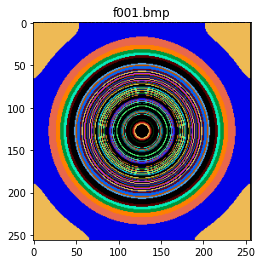

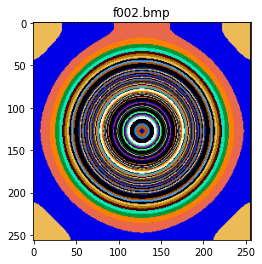

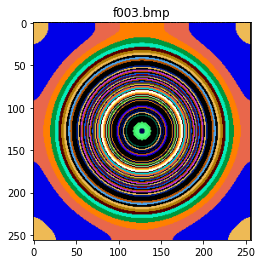

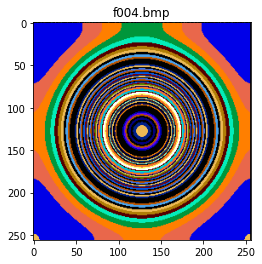

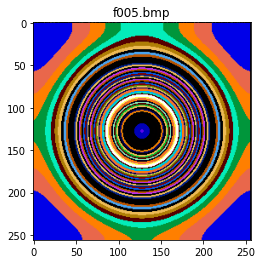

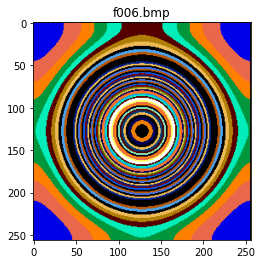

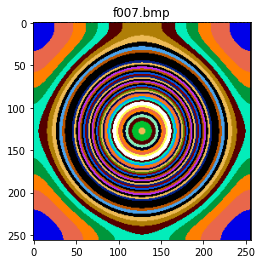

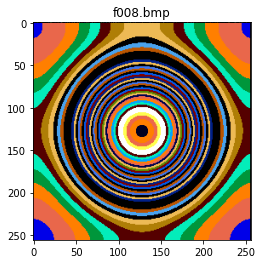

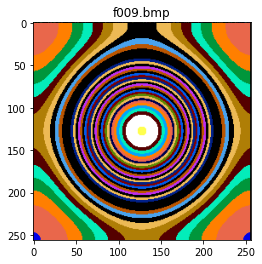

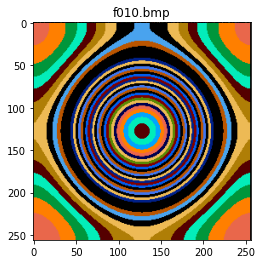

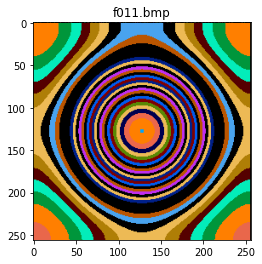

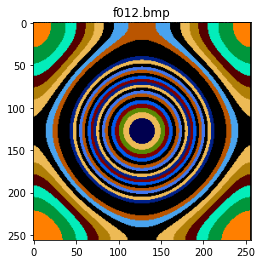

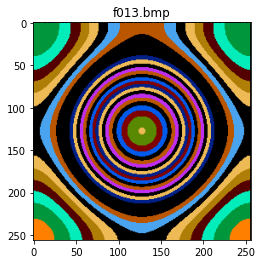

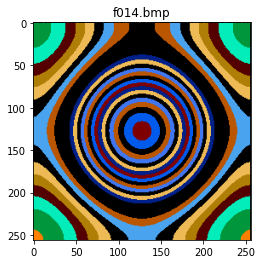

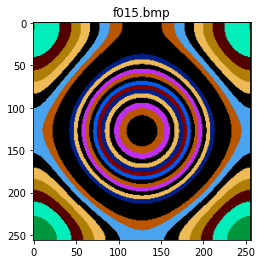

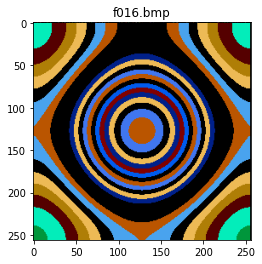

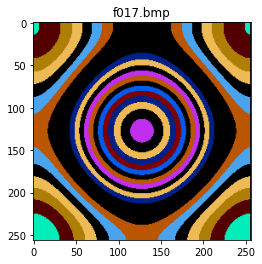

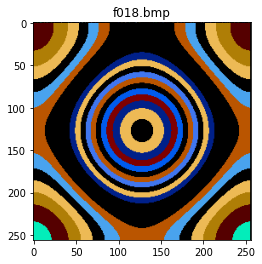

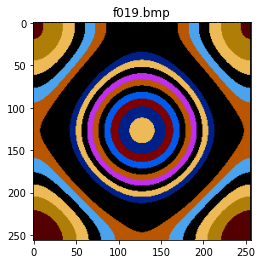

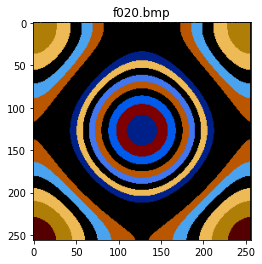

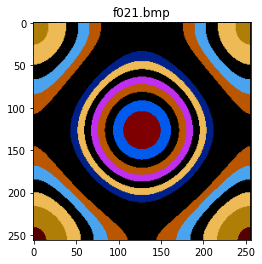

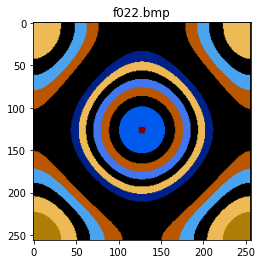

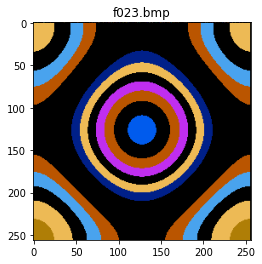

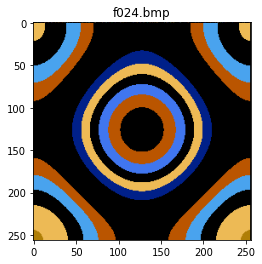

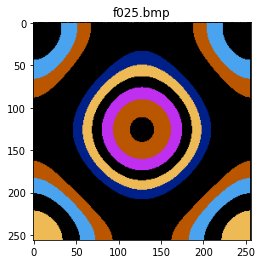

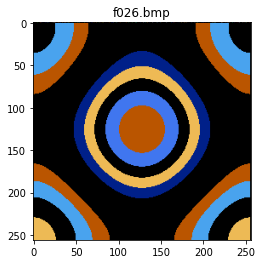

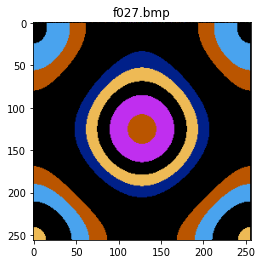

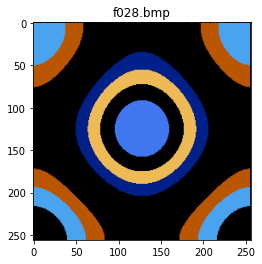

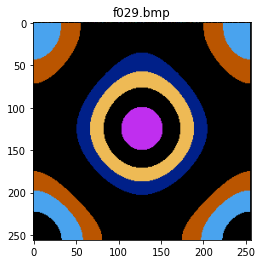

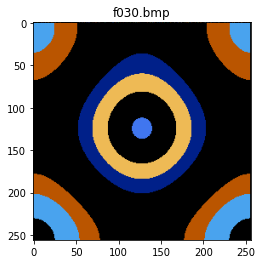

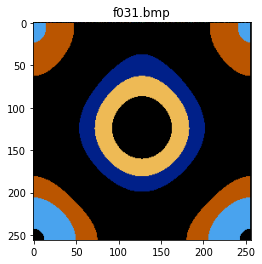

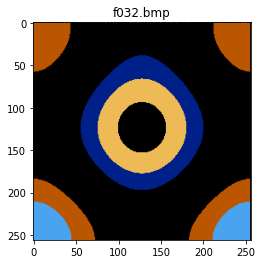

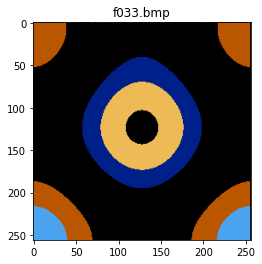

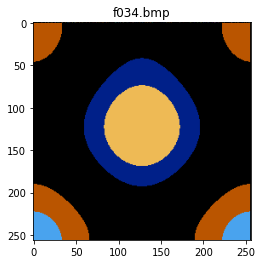

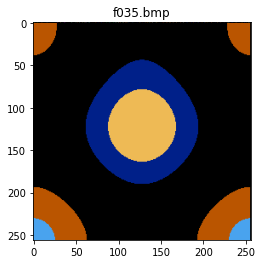

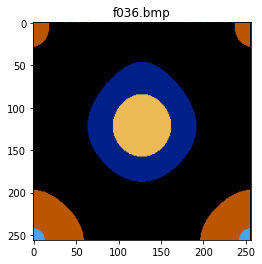

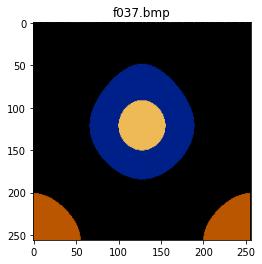

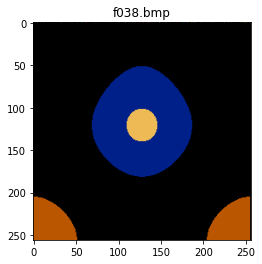

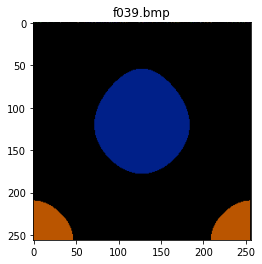

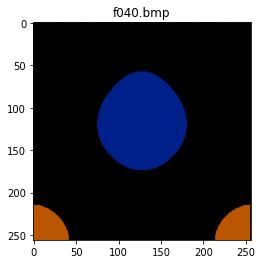

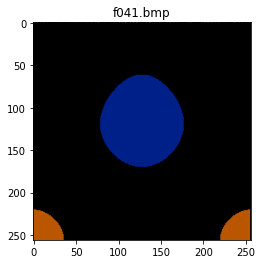

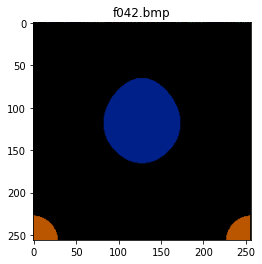

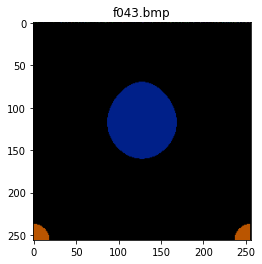

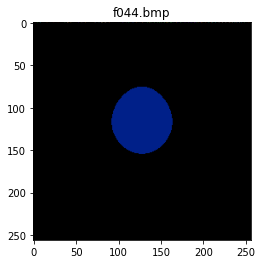

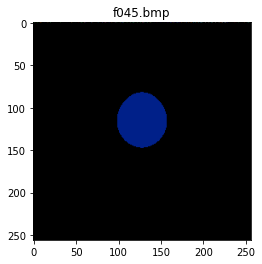

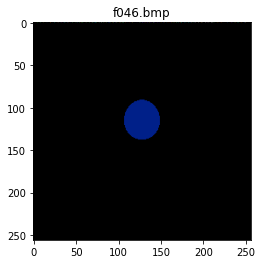

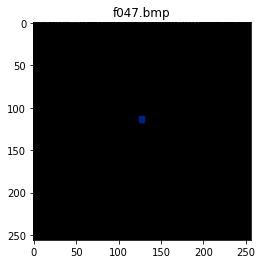

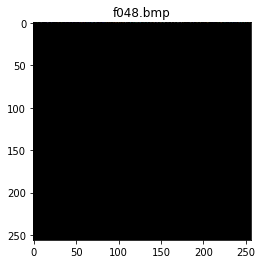

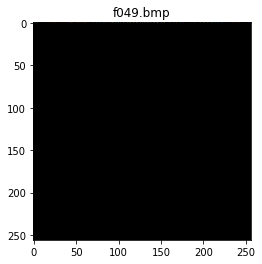

In [20]:
from skimage import io
import matplotlib.pyplot as plt
import time

# フォルダのパス
folder_path = '/content/new_bmps'

# フォルダ内のファイルのリストを取得
bmp_files = os.listdir(folder_path)

# Sort the list of image files by the numbers in the file names
sorted_files = sorted(bmp_files, key=lambda x: int(x[1:4]))

# Loop over the sorted list of image files
for file in sorted_files:
  # Read the BMP file into a NumPy array
  try:
    # Construct the full path of the image file
    file_path = os.path.join(folder_path, file)
    image = io.imread(file_path)
    # Display the image
    plt.imshow(image)
    plt.title(file)  # Add a title to the image
    plt.show()
    time.sleep(0.3)  # Add a delay of 0.3 second between each image
  except:
    # Catch any errors that may occur during the reading process
    print(f"Error reading file {file}")

